In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

**Import pickeled data file with 4hr interval entries and exits per turnstile**

In [2]:
with open('spatial_4hr_interval_mta.pickle','rb') as read_file:
    time_series_df = pickle.load(read_file)

In [3]:
time_series_df.shape

(2519821, 16)

In [4]:
time_series_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,ENTRIES,EXITS,DATE_TIME,DATE,DESC,TIME_INTERVAL,ENTRY_DIFF,EXIT_DIFF,LAT,LONG,ZIPCODE
0,A002,R051,02-00-00,59 ST,NQR456W,6566470.0,2224053.0,2018-03-31 03:59:00,2018-03-31,REGULAR,04:00:00,7.0,3.0,40.762796,-73.967686,10022
1,A002,R051,02-00-00,59 ST,NQR456W,6566470.0,2224053.0,2018-03-31 07:59:00,2018-03-31,REGULAR,04:00:00,0.0,0.0,40.762796,-73.967686,10022
2,A002,R051,02-00-00,59 ST,NQR456W,6566470.0,2224055.0,2018-03-31 11:59:00,2018-03-31,REGULAR,04:00:00,0.0,2.0,40.762796,-73.967686,10022
3,A002,R051,02-00-00,59 ST,NQR456W,6566470.0,2224055.0,2018-03-31 15:59:00,2018-03-31,REGULAR,04:00:00,0.0,0.0,40.762796,-73.967686,10022
4,A002,R051,02-00-00,59 ST,NQR456W,6566470.0,2224055.0,2018-03-31 19:59:00,2018-03-31,REGULAR,04:00:00,0.0,0.0,40.762796,-73.967686,10022


**ENTRIES per day at each subway station/line combination**

In [5]:
grouping = ['STATION','LINENAME','DATE']


In [6]:
daily_entries_per_station_line = time_series_df.groupby(by=grouping)['ENTRY_DIFF'].sum().reset_index()

#DOES EVERYTHING ELSE COME WITH IT? No, it is dropped!


In [7]:
daily_entries_per_station_line.shape

(42953, 4)

In [8]:
daily_entries_per_station_line['ENTRY_DIFF'].max()

362547.0

In [9]:
zero_mask_entries = (daily_entries_per_station_line.ENTRY_DIFF == 0)
daily_entries_per_station_line[zero_mask_entries].shape[0]

208

In [10]:
daily_entries_per_station_line.head()

,STATION,LINENAME,DATE,ENTRY_DIFF
0,1 AV,L,2018-03-31,16546.0
1,1 AV,L,2018-04-01,12075.0
2,1 AV,L,2018-04-02,18415.0
3,1 AV,L,2018-04-03,19832.0
4,1 AV,L,2018-04-04,20644.0


**EXITS per day at each subway station/line combination**

In [11]:
daily_exits_per_station_line = time_series_df.groupby(by=grouping)['EXIT_DIFF'].sum().reset_index()

In [12]:
daily_exits_per_station_line.shape

(42953, 4)

In [13]:
daily_exits_per_station_line['EXIT_DIFF'].max()

454117.0

In [14]:
zero_mask_exits = (daily_exits_per_station_line.EXIT_DIFF == 0)
daily_exits_per_station_line[zero_mask_exits].shape[0]

214

In [15]:
daily_exits_per_station_line.head()

,STATION,LINENAME,DATE,EXIT_DIFF
0,1 AV,L,2018-03-31,18089.0
1,1 AV,L,2018-04-01,13945.0
2,1 AV,L,2018-04-02,19708.0
3,1 AV,L,2018-04-03,22533.0
4,1 AV,L,2018-04-04,22280.0


**Merge daily entries and exits by station-line into a single data file**

In [16]:
daily_station_line_counts = pd.merge(daily_entries_per_station_line, daily_exits_per_station_line, on=['STATION', 'LINENAME', 'DATE'])

In [17]:
daily_station_line_counts.head()

,STATION,LINENAME,DATE,ENTRY_DIFF,EXIT_DIFF
0,1 AV,L,2018-03-31,16546.0,18089.0
1,1 AV,L,2018-04-01,12075.0,13945.0
2,1 AV,L,2018-04-02,18415.0,19708.0
3,1 AV,L,2018-04-03,19832.0,22533.0
4,1 AV,L,2018-04-04,20644.0,22280.0


In [18]:
daily_station_line_counts.shape

(42953, 5)

**Remove days with zero ENTRIES or EXITS from the dataset. Assumption: subway stations that had 0 entries or exits for a full 24 hours are incorrect data or were closed, so removed**

In [19]:
daily_station_line_counts= daily_station_line_counts[daily_station_line_counts.ENTRY_DIFF != 0]

In [20]:
daily_station_line_counts= daily_station_line_counts[daily_station_line_counts.EXIT_DIFF != 0]

In [21]:
daily_station_line_counts.shape

(42586, 5)

In [22]:
daily_station_line_counts.dtypes

STATION        object
LINENAME       object
DATE           object
ENTRY_DIFF    float64
EXIT_DIFF     float64
dtype: object

**Get summed daily entries and exits for each day, by Station and Line**

In [23]:
daily_station_line_counts['DAILY_TOTAL'] = daily_station_line_counts['ENTRY_DIFF'] + daily_station_line_counts['EXIT_DIFF']

In [25]:
daily_station_line_counts.head()

,STATION,LINENAME,DATE,ENTRY_DIFF,EXIT_DIFF,DAILY_TOTAL
0,1 AV,L,2018-03-31,16546.0,18089.0,34635.0
1,1 AV,L,2018-04-01,12075.0,13945.0,26020.0
2,1 AV,L,2018-04-02,18415.0,19708.0,38123.0
3,1 AV,L,2018-04-03,19832.0,22533.0,42365.0
4,1 AV,L,2018-04-04,20644.0,22280.0,42924.0


In [120]:
weekly_station_line_counts = daily_station_line_counts[['DATE','DAILY_TOTAL']]
weekly_station_line_counts['NUM_WEEK'] = pd.to_datetime(daily_station_line_counts['DATE']).dt.week
weekly_station_line_counts.head(2)
weekly_station_line_counts = weekly_station_line_counts.groupby(by=['NUM_WEEK'])['DAILY_TOTAL'].sum()#.reset_index()
weekly_station_line_counts = weekly_station_line_counts.sort_values().reset_index()#by=['DAILY_TOTAL'], ascending=True)
weekly_station_line_counts.tail(10)

#Date represents the number of week
#NUM_WEEK represents weekly total
#Daily_Total is suppose to be Weekly_Total but I didn't rewrite the column name
#weekly_station_line_counts hold NUM_WEEK and Daily_Total
#I did the Top 10, but it can be ordered for any way.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,NUM_WEEK,DAILY_TOTAL
4,21,61198323.0
5,24,62575327.0
6,23,62809306.0
7,25,62901036.0
8,20,62970249.0
9,16,63022018.0
10,17,63029702.0
11,15,63101474.0
12,19,63570399.0
13,18,64052046.0


<BarContainer object of 14 artists>

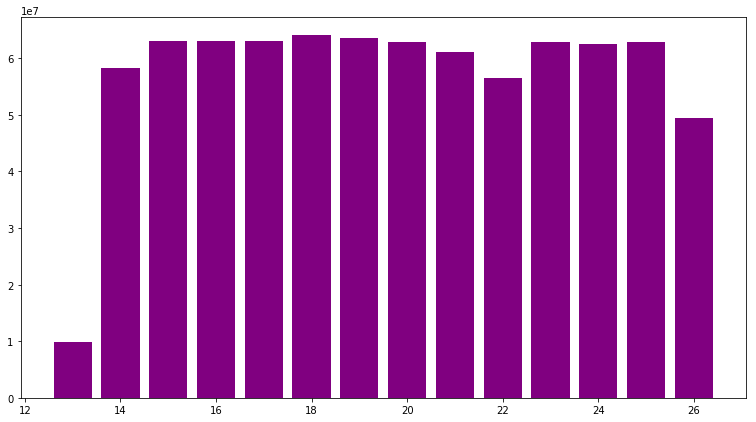

In [123]:
plt.figure(figsize=(13, 7))  # 
#plt.bar(weekly_station_line_counts["DATE"], weekly_station_line_counts["DAILY_TOTAL"],align='center', width=0.5);
plt.bar(weekly_station_line_counts["NUM_WEEK"],
        weekly_station_line_counts["DAILY_TOTAL"],
        color='purple',
        edgecolor='none',
        width=0.8,
        align='center',
        label='y')
#plt.ylim(ymin= 61000000) #Sets the lowest y-value to start the y-values
#plt.ylim(ymax = 64500000) #Sets the higest y-value to start the y-values
#Note: struggling to get all the ticks for the x axis.

In [76]:
#NO: weekly_station_line_count = pd.to_datetime(daily_station_line_counts['DATE']).dt.week BUT WHY?
#daily_station_line_counts['DATE'] = daily_station_line_counts['DATE']
#weekly_station_line_counts = pd.to_datetime(daily_station_line_counts['DATE']).dt.week#.reset_index() #WhydoIrestindex before:( now :)
#weekly_station_line_counts.head(20)
#weekly_station_line_counts['WEEKLY_TOTAL'] = daily_station_line_counts['DAILY_TOTAL']
#weekly_station_line_counts = weekly_station_line_counts.groupby(by=['DATE'])['WEEKLY_TOTAL'].sum().reset_index()
#weekly_station_line_counts.head(20)
#weekly_station_line_counts = weekly_station_line_counts.sort_values(by=['DATE'], ascending=False).head(10)
#weekly_station_line_counts.head(100)
#.sort_values(by=['C/A','UNIT','SCP','STATION','LINENAME','DATE_TIME'])
#weekly_station_line_count = daily_station_line_counts['DATE']
#weekly_station_line_count['WEEK_NUM'] = pd.to_datetime(daily_station_line_counts['DATE']).dt.week
#weekly_station_line_count.head(2)

In [26]:
#WILL ATTEMPT TO GET THEM BY WEEK
#NEEDS TO FOLLOW LINE 22 ("daily_station_line_counts['DAILY_TOTAL'] = daily_station_line_counts['ENTRY_DIFF'] + daily_station_line_counts['EXIT_DIFF']")
#weekly_station_line_counts = [] 
#daily_station_line_counts['DATE'] = pd.to_datetime(daily_station_line_counts['DATE']).dt.day
#weekly_station_line_counts['WEEK_NUM'] = pd.to_datetime(daily_station_line_counts['DATE']).dt.week
#weekly_station_line_counts.head(30)
#weekly_station_line_counts.groupby(by=['STATION', 'LINENAME', 'DATE'])['DAILY_TOTAL'].sum().reset_index()
#weekly_station_line_counts= weekly_station_line_counts.groupby(by=['WEEK_NUM'])['WEEKLY_TOTAL'].sum().reset_index().sort_values(by="DAILY_TOTAL", ascending=False).head(10)
#weekly_station_line_counts.head(30)
#daily_station_line_counts['DATE'] = pd.to_datetime(daily_station_line_counts['DATE'])
#daily_station_line_counts.head(3)
#weekly_station_line_counts = [] 
#weekly_station_line_counts['WEEK_NUM'] = pd.to_datetime(daily_station_line_counts['DATE']).dt.week
#weekly_station_line_counts.head(1)


In [102]:
daily_station_line_counts['DAILY_TOTAL'].max()

620725.0

**Save the daily totals by station-line file**

In [103]:
with open('daily_station_line_counts.pickle', 'wb') as to_write:
    pickle.dump(daily_station_line_counts, to_write)

In [104]:
with open('daily_station_line_counts.pickle','rb') as read_file:
    daily_station_line_counts = pickle.load(read_file)

In [105]:
daily_station_line_counts.head()

,STATION,LINENAME,DATE,ENTRY_DIFF,EXIT_DIFF,DAILY_TOTAL
0,1 AV,L,2018-03-31,16546.0,18089.0,34635.0
1,1 AV,L,2018-04-01,12075.0,13945.0,26020.0
2,1 AV,L,2018-04-02,18415.0,19708.0,38123.0
3,1 AV,L,2018-04-03,19832.0,22533.0,42365.0
4,1 AV,L,2018-04-04,20644.0,22280.0,42924.0


**Get total counts per station-line - over the entire season of April/May/June**

In [106]:
#
total_spring_station_line_counts = daily_station_line_counts.groupby(by=['STATION', 'LINENAME'])['DAILY_TOTAL'].sum().reset_index()
total_spring_station_line_counts.head(5)

,STATION,LINENAME,DAILY_TOTAL
0,1 AV,L,3928010.0
1,103 ST,1,1602524.0
2,103 ST,6,1983593.0
3,103 ST,BC,807476.0
4,103 ST-CORONA,7,2812681.0


In [107]:
total_spring_station_line_counts.rename(columns={'DAILY_TOTAL': 'SPRING_TOTAL'}, inplace=True)
total_spring_station_line_counts.head(5)



,STATION,LINENAME,SPRING_TOTAL
0,1 AV,L,3928010.0
1,103 ST,1,1602524.0
2,103 ST,6,1983593.0
3,103 ST,BC,807476.0
4,103 ST-CORONA,7,2812681.0


In [108]:
top10_totalspring = total_spring_station_line_counts.sort_values(by="SPRING_TOTAL", ascending=False).head(10)
top10_totalspring.head(2)

,STATION,LINENAME,SPRING_TOTAL
312,GRD CNTRL-42 ST,4567S,21730974.0
89,34 ST-HERALD SQ,BDFMNQRW,17172214.0


**Top 10 Stations of Entries for the Spring of 2018**

(5500000, 22817522.7)

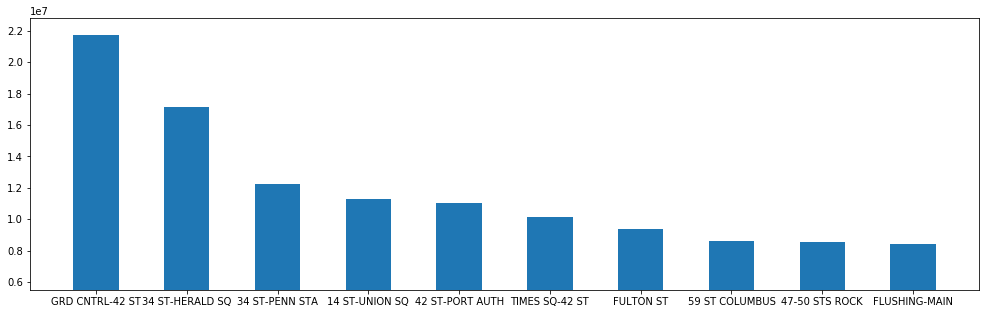

In [119]:
plt.figure(figsize=(17, 5))  # width:20, height:3
plt.bar(top10_totalspring["STATION"], top10_totalspring["SPRING_TOTAL"],align='center', width=0.5);
plt.ylim(ymin= 5500000) #Sets the lowest y-value to start the y-values
#plt.ylim(ymax = 64500000)
#How do add labels for x and y?

** Top 10 Stations of Entries for Average Weekly Ridership **